## Data

In [1]:
!python3 --version

Python 3.9.0


In [2]:
import epics
import numpy
import pandas
import torch

from harmonica.util import LIMIT, LENGTH, pv_make
from harmonica.window import Window
from harmonica.data import Data

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
torch.cuda.is_available()

True

In [3]:
# Example-01: Empty data initialization

# Set (empty) window
win = Window(length=1024, dtype=torch.float64, device='cpu')
print(win)

# Set (emply) TbT data
tbt = Data(size=54, window=win)
print(tbt)

# Number of signals in data
print(tbt.size)
print(len(tbt))

# Signal length (defined by window length)
print(tbt.length)

# Window data
print(tbt.window.data.detach().cpu().numpy())

# Data contaner dtype and device for data and work (define by window)
print(tbt.dtype)
print(tbt.device)

# TbT data
print(tbt.data.shape)
print(tbt.data.detach().cpu().numpy())

# TbT work, stores a copy of data (window or normalization is applied to work)
print(tbt.work.shape)
print(tbt.work.detach().cpu().numpy())

# Initialization source, 'empty' for empty initialization
print(tbt.source)

# Get item
print(tbt.data[0].detach().cpu().numpy())
print(tbt[0].detach().cpu().numpy())

# Set data (resets work)
tbt.set_data(torch.randn(tbt.data.shape, dtype=tbt.dtype, device=tbt.device))
print(tbt.data.detach().cpu().numpy())
print(tbt.work.detach().cpu().numpy())

# If data is modified directly, use reset to update work
tbt.data.copy_(torch.randn(tbt.data.shape, dtype=tbt.dtype, device=tbt.device))
tbt.reset()
print(tbt.data.detach().cpu().numpy())
print(tbt.work.detach().cpu().numpy())

# Reset window
tbt.window.set_data(name='cosine_window', order=1.0)
print(win)

Window(1024, None, None)
Data(54, Window(1024, None, None))
54
54
1024
[1. 1. 1. ... 1. 1. 1.]
torch.float64
cpu
torch.Size([54, 1024])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
torch.Size([54, 1024])
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
empty
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[[ 0.77317283 -0.23037829  0.5022491  ... -0.63563389 -0.27560814
  -0.41343091]
 [ 2.77015099  2.89390065 -0.25854601 ...  0.47278773 -0.60674248
   0.95226095]
 [ 0.92130694  0.48028593 -0.06681692 ... -0.99590081  0.08497908
  -0.64868693]
 ...
 [ 0.16562677 -1.80048653 -0.13858387 ...  0.55383016 -0.60302961
   1.28428591]
 [-1.16453936  1.40534451 -0.68935755 ... -1.20779384  1.24213375
  -0.10379144]
 [-1.87400932 -0.75451281  0.60855591 ... -0.46509926  0.76275608

In [4]:
# Example-02: Free CUDA

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Set window and data
win = Window(length=1024, dtype=torch.float32, device=device)
tbt = Data(size=54, window=win)
print(torch.cuda.memory_allocated())
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

446464
0


In [5]:
# Example-03: Initialize from tensor

# Set window
win = Window(length=1024, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Set input tensor (length should match window length)
dat = torch.ones((54, win.length), dtype=win.dtype, device=win.device)

# Initialize data
tbt = Data.from_tensor(window=win, tensor=dat)
print(tbt)

# Info
print(tbt.size)
print(tbt.length)
print(tbt.source)
print(tbt.data.shape)
print(tbt.data.detach().cpu().numpy())
print(tbt.work.shape)
print(tbt.work.detach().cpu().numpy())

# Clean
del win
del dat
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(54, Window(1024, 'cosine_window', 1.0))
54
1024
tensor
torch.Size([54, 1024])
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
torch.Size([54, 1024])
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [6]:
# Example-04: Initialization from harmonics data

# This initialization can be used to generate test data from given harmonics parameters
# Another option is to create empty instance and set data and work containers or from_tensor (classmethod)

# Set window
win = Window(length=8192, name='cosine_window', order=1.0, dtype=torch.float64, device='cpu')
print(win)

# Set harmonics

# Generate two signals with three harmonics in each signal
# Each signal 'i' is a sum over harmonics 'j'
# s_i(n) = m_i + ... + c_i_j*cos(2*pi*nu_i_j*n) + s_i_j*sin(2*pi*nu_i_j*n) + ..., n = 1, ..., length

mean = torch.tensor([[0.5], [1.0]], dtype=win.dtype, device=win.device)
frequency = torch.tensor([[[0.1], [0.2], [0.3]], [[0.12], [0.23], [0.34]]], dtype=win.dtype, device=win.device)
c_amp = torch.tensor([[[5.0], [0.5], [0.1]], [[5.5], [1.5], [4.1]]], dtype=win.dtype, device=win.device)
s_amp = torch.tensor([[[0.1], [0.5], [1.0]], [[0.2], [0.6], [4.0]]], dtype=win.dtype, device=win.device)

print(mean.shape)
print(frequency.shape)
print(c_amp.shape)
print(s_amp.shape)

# Harmonics can be generated with Data.generate_harmonics (staticmethod)
# This requires a data container
# An empty Data instance can be created and data container can be modified

tbt = Data(size=2, window=win)
print(tbt)
print(tbt.data.detach().cpu().numpy())
print(tbt.work.detach().cpu().numpy())

Data.generate_harmonics(tbt.data, mean, frequency, c_amp, s_amp)
print(tbt.data.detach().cpu().numpy())
print(tbt.work.detach().cpu().numpy())
tbt.reset()
print(tbt.work.detach().cpu().numpy())

# Initiallize using a class method
tbt = Data.from_harmonics(2, win, mean, frequency, c_amp, s_amp, std=None)
print(tbt)
print(tbt.data.detach().cpu().numpy())
print(tbt.work.detach().cpu().numpy())

# Check data frequencies (largest bin in FFT spectrum)
print(torch.argmax(torch.abs(torch.fft.fft(tbt.data, 1000)), 1).to(torch.float64).div_(1000).numpy())

# Check amplitudes
time = 2.0*numpy.pi*torch.linspace(1, tbt.length, tbt.length, dtype=win.dtype, device=win.device)
for i in range(tbt.size):
    print((2*torch.sum(tbt.window.data*tbt[i]*torch.cos(time*frequency[i]), 1)/tbt.length).numpy())
    print((2*torch.sum(tbt.window.data*tbt[i]*torch.sin(time*frequency[i]), 1)/tbt.length).numpy())
    
# Generate 54 signals with one harmonic and normal noise and save to file
size = 54
mean = torch.rand((size, 1), dtype=win.dtype, device=win.device)
frequency = torch.rand((size, 1, 1), dtype=win.dtype, device=win.device)
c_amp = torch.rand((size, 1, 1), dtype=win.dtype, device=win.device)
s_amp = torch.rand((size, 1, 1), dtype=win.dtype, device=win.device)
std = 0.001*torch.rand(size, dtype=win.dtype, device=win.device)
tbt = Data.from_harmonics(size, win, mean, frequency, c_amp, s_amp, std)
print(tbt)
print(tbt.data.detach().cpu().numpy())
tbt.save_data('test.npy')

# Load saved data
print(numpy.load('test.npy'))

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(8192, 'cosine_window', 1.0)
torch.Size([2, 1])
torch.Size([2, 3, 1])
torch.Size([2, 3, 1])
torch.Size([2, 3, 1])
Data(2, Window(8192, 'cosine_window', 1.0))
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 6.15405507  1.3608878  -2.155264   ...  6.1         6.15405507
   1.3608878 ]
 [ 7.10992739 -5.12371091  1.10722119 ... -4.19288792  9.16469439
  10.84816792]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 6.15405507  1.3608878  -2.155264   ...  6.1         6.15405507
   1.3608878 ]
 [ 7.10992739 -5.12371091  1.10722119 ... -4.19288792  9.16469439
  10.84816792]]
Data(2, Window(8192, 'cosine_window', 1.0))
[[ 6.15405507  1.3608878  -2.155264   ...  6.1         6.15405507
   1.3608878 ]
 [ 7.10992739 -5.12371091  1.10722119 ... -4.19288792  9.16469439
  10.84816792]]
[[ 6.15405507  1.3608878  -2.155264   ...  6.1         6.15405507
   1.3608878 ]
 [ 7.10992739 -5.12371091  1.10722119 ... -4.19288792  9.16469439
  1

In [7]:
# Example-05: Initialization from file

# This initialization can be used to load TbT data from file (numpy)
# Data also can be loaded into given instance using load_data method (updates work container)
# In this case input size and length should match data container

# Set window
win = Window(length=8192, dtype=torch.float64, device='cpu')
print(win)

# Initialize from file
tbt = Data.from_file(54, win, 'test.npy')
print(tbt)
print(tbt.data.detach().cpu().numpy())
print(tbt.work.detach().cpu().numpy())

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(8192, None, None)
Data(54, Window(8192, None, None))
[[ 0.13469151  0.8582574   0.92017074 ...  1.29677734 -0.10041199
   1.40622103]
 [-0.71664112 -0.65748709  1.19920307 ...  1.26320753 -0.57416123
  -0.78901237]
 [ 1.36463     1.37202334  1.23087991 ...  0.189068   -0.01251289
  -0.07443274]
 ...
 [-0.65421797  1.05262979 -0.91444418 ... -0.44572604  0.92791715
  -0.89347782]
 [-0.50336276 -0.80603459 -0.13046431 ...  0.03244006 -0.75557228
  -0.6178883 ]
 [ 0.0591749   0.83534623  0.1110411  ... -0.11802836  1.01854566
  -0.08079195]]
[[ 0.13469151  0.8582574   0.92017074 ...  1.29677734 -0.10041199
   1.40622103]
 [-0.71664112 -0.65748709  1.19920307 ...  1.26320753 -0.57416123
  -0.78901237]
 [ 1.36463     1.37202334  1.23087991 ...  0.189068   -0.01251289
  -0.07443274]
 ...
 [-0.65421797  1.05262979 -0.91444418 ... -0.44572604  0.92791715
  -0.89347782]
 [-0.50336276 -0.80603459 -0.13046431 ...  0.03244006 -0.75557228
  -0.6178883 ]
 [ 0.0591749   0.83534623  0.1110411  

In [8]:
# Example-06: Put test data to epics

# softIoc -d virtual_tbt.db

# Set window
win = Window(8192, dtype=torch.float64, device='cpu')
print(win)

# Load data from file
tbt = Data.from_file(54, win, 'test.npy')
print(tbt)
print(tbt.source)

# Set list of pv names and starting indices
bpm = ["STP2", "STP4", "SRP1", "SRP2", "SRP3", "SRP4", "SRP5", "SRP6", "SRP7", "SRP8", "SRP9", "SIP1", "SIP2", "SRP10", "SRP11", "SRP12", "SRP13", "SRP14", "SRP15", "SRP16", "SRP17", "SEP5", "SEP4", "SEP3", "SEP1", "SEP0", "NEP0", "NEP1", "NEP3", "NEP4", "NEP5", "NRP17", "NRP16", "NRP15", "NRP14", "NRP13", "NRP12", "NRP11", "NRP10", "NIP3", "NIP1", "NRP9", "NRP8", "NRP7", "NRP6", "NRP5", "NRP4", "NRP3", "NRP2", "NRP1", "NTP4", "NTP2", "NTP0", "STP0"]
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

# Put tensor to PV
Data.pv_put('TEST:STP2:turns_x-I', tbt[0])

# Get tensor from PV
print(Data.pv_get('TEST:STP2:turns_x-I', count=1, dtype=tbt.dtype, device=tbt.device))
print(epics.caget('TEST:STP2:turns_x-I', count=1))

# Set PVs with loop
for name, signal in zip(pv_list, tbt):
     Data.pv_put(name, signal)
        
# Set PVs with save_epics (Data instance is expected to have pv_list attribute)
tbt.pv_list = pv_list
tbt.save_epics()

# Load data from PVs
# Data instance should have pv_rise attribute
tbt.pv_rise = pv_rise
tbt.load_epics(shift=0, count=8192)
print(tbt.data[0, 0:1])

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(8192, None, None)
Data(54, Window(8192, None, None))
file
tensor([2.098596534716e-03], dtype=torch.float64)
[0.13469151]
tensor([1.346915132956e-01], dtype=torch.float64)


In [9]:
# Example-07: Initialization from epics

# softIoc -d virtual_tbt.db

# Use to load data from list of PV names
# Optionaly provide a list of starting values and shift for all PVs

# Set window
win = Window(1024, 'cosine_window', 1.0, dtype=torch.float64, device='cpu')
print(win)

# Set list of pv names and starting indices
bpm = ["STP2", "STP4", "SRP1", "SRP2", "SRP3", "SRP4", "SRP5", "SRP6", "SRP7", "SRP8", "SRP9", "SIP1", "SIP2", "SRP10", "SRP11", "SRP12", "SRP13", "SRP14", "SRP15", "SRP16", "SRP17", "SEP5", "SEP4", "SEP3", "SEP1", "SEP0", "NEP0", "NEP1", "NEP3", "NEP4", "NEP5", "NRP17", "NRP16", "NRP15", "NRP14", "NRP13", "NRP12", "NRP11", "NRP10", "NIP3", "NIP1", "NRP9", "NRP8", "NRP7", "NRP6", "NRP5", "NRP4", "NRP3", "NRP2", "NRP1", "NTP4", "NTP2", "NTP0", "STP0"]
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

# Set data
tbt = Data.from_epics(54, win, pv_list, pv_rise, 16, 2048)
print(tbt)
print(tbt.source)
print(tbt.data.detach().cpu().numpy())
print(tbt.work.detach().cpu().numpy())

# Change one PV
Data.pv_put('TEST:STP2:turns_x-I', tbt[0].mul_(0.0).add(1.0))

# On call, data and work are reloaded
tbt()
print(tbt.data.detach().cpu().numpy())
print(tbt.work.detach().cpu().numpy())

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 1.0)
Data(54, Window(1024, 'cosine_window', 1.0))
epics
[[ 1.46815987 -0.00782445  1.07583632 ...  0.63979802  0.31287626
   1.35293417]
 [-1.07948503  0.41856863  1.44159072 ...  1.35184455  0.68050235
  -1.01805004]
 [ 1.15941494  0.87180902  0.53936015 ...  0.59816693  0.92786697
   1.20027275]
 ...
 [-0.70015822  1.07318044 -0.90876201 ... -0.76007419  1.0957497
  -0.8900837 ]
 [ 0.68481003 -0.27499415 -0.82868957 ... -0.7864462  -0.05811205
   0.84365792]
 [ 0.52141682  0.36928582  0.58087892 ...  0.23778731  0.70976158
   0.18181276]]
[[ 1.46815987 -0.00782445  1.07583632 ...  0.63979802  0.31287626
   1.35293417]
 [-1.07948503  0.41856863  1.44159072 ...  1.35184455  0.68050235
  -1.01805004]
 [ 1.15941494  0.87180902  0.53936015 ...  0.59816693  0.92786697
   1.20027275]
 ...
 [-0.70015822  1.07318044 -0.90876201 ... -0.76007419  1.0957497
  -0.8900837 ]
 [ 0.68481003 -0.27499415 -0.82868957 ... -0.7864462  -0.05811205
   0.84365792]
 [ 0.52141682 

In [10]:
# Example-08: Generate new TbT data from given signal

# Set initial data
size, length = 1, 8
win = Window(length)
tbt = Data.from_tensor(win, torch.linspace(1, length, length).reshape(1, -1))
print(tbt.data.detach().cpu().numpy())

# Generate new data
tbt = tbt.make_matrix(0, 4, 1)
print(tbt.data.detach().cpu().numpy())

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

[[1. 2. 3. 4. 5. 6. 7. 8.]]
[[1. 2. 3. 4.]
 [2. 3. 4. 5.]
 [3. 4. 5. 6.]
 [4. 5. 6. 7.]
 [5. 6. 7. 8.]]


In [11]:
# Example-9: Generate new data (mixed signal)

# Set initial data
size, length = 4, 8
win = Window(length)
tbt = Data.from_tensor(win, torch.tensor([[_ for _ in range(length)] for _ in range(size)]))
print(tbt.data.detach().cpu().numpy())

# Generate new data
tbt = tbt.make_signal(4)
print(tbt.data.detach().cpu().numpy())

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

[[0. 1. 2. 3. 4. 5. 6. 7.]
 [0. 1. 2. 3. 4. 5. 6. 7.]
 [0. 1. 2. 3. 4. 5. 6. 7.]
 [0. 1. 2. 3. 4. 5. 6. 7.]]
[[0. 0. 0. 0. 1. 1. 1. 1. 2. 2. 2. 2. 3. 3. 3. 3.]]


In [12]:
# Example-10: Indexing by PV name

# softIoc -d virtual_tbt.db

# Set parameters
dtype, device = torch.float64, 'cpu'
size, length = 54, 1024

# Set list of pv names and starting indices
bpm = ["STP2", "STP4", "SRP1", "SRP2", "SRP3", "SRP4", "SRP5", "SRP6", "SRP7", "SRP8", "SRP9", "SIP1", "SIP2", "SRP10", "SRP11", "SRP12", "SRP13", "SRP14", "SRP15", "SRP16", "SRP17", "SEP5", "SEP4", "SEP3", "SEP1", "SEP0", "NEP0", "NEP1", "NEP3", "NEP4", "NEP5", "NRP17", "NRP16", "NRP15", "NRP14", "NRP13", "NRP12", "NRP11", "NRP10", "NIP3", "NIP1", "NRP9", "NRP8", "NRP7", "NRP6", "NRP5", "NRP4", "NRP3", "NRP2", "NRP1", "NTP4", "NTP2", "NTP0", "STP0"]
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

win = Window(1024, dtype=dtype, device=device)
print(win)
tbt = Data.from_epics(size, win, pv_list, pv_rise, count=1024)
print(tbt)

# Index by position or PV name (if epics)
print(tbt[0].detach().cpu().numpy())
print(tbt["TEST:STP2:turns_x-I"].detach().cpu().numpy())

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, None, None)
Data(54, Window(1024, None, None))
[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]


In [13]:
# Example-11: Put to all PVs

# softIoc -d virtual_tbt.db

# Set list of pv names and starting indices
bpm = ["STP2", "STP4", "SRP1", "SRP2", "SRP3", "SRP4", "SRP5", "SRP6", "SRP7", "SRP8", "SRP9", "SIP1", "SIP2", "SRP10", "SRP11", "SRP12", "SRP13", "SRP14", "SRP15", "SRP16", "SRP17", "SEP5", "SEP4", "SEP3", "SEP1", "SEP0", "NEP0", "NEP1", "NEP3", "NEP4", "NEP5", "NRP17", "NRP16", "NRP15", "NRP14", "NRP13", "NRP12", "NRP11", "NRP10", "NIP3", "NIP1", "NRP9", "NRP8", "NRP7", "NRP6", "NRP5", "NRP4", "NRP3", "NRP2", "NRP1", "NTP4", "NTP2", "NTP0", "STP0"]
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

# Generate test data
frequency = 0.123456
time = torch.linspace(1, 4096, 4096, dtype=torch.float64)
dat = [(10.0 + torch.randn(1)) * torch.cos(2.0*numpy.pi*frequency*time) for _ in pv_list]
dat = torch.stack(dat) + 1.0

# Set data 
win = Window(4096, dtype=torch.float64)
tbt = Data.from_tensor(win, dat)
print(win)
print(tbt)

# Add attibutes
tbt.pv_list = pv_list
tbt.pv_rise = pv_rise
tbt.data[0, 128].add_(+25.0)
tbt.data[5, 256].add_(-25.0)
tbt.save_epics()

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, None, None)
Data(54, Window(4096, None, None))


Window(1024, 'cosine_window', 5.0)
Data(1, Window(1024, 'cosine_window', 5.0))
tensor([1.000000000000e+00], dtype=torch.float64)
tensor([1.000000000000e+00], dtype=torch.float64)
tensor([-0.], dtype=torch.float64)


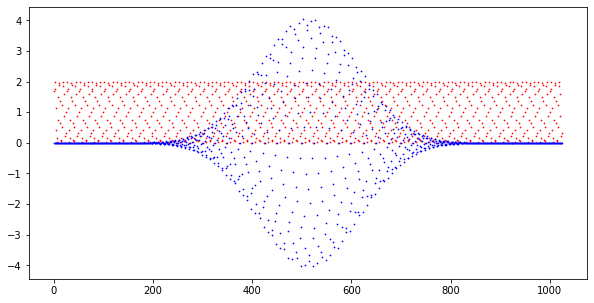

In [14]:
# Example-12: Operations with window

# tbt.window_mean           -- return window weighted mean
# tbt.window_remove_mean    -- copy data to work with removed window weighted mean
# tbt.window_apply          -- apply window to work

# Set window
win = Window.from_cosine(1024, 5.0, dtype=torch.float64, device='cpu')
print(win)

# Set tbt
tbt = Data.from_tensor(win, torch.stack([1.0 + torch.sin(2.0*numpy.pi*0.12*torch.linspace(1, 1024, 1024, dtype=win.dtype, device=win.device))]))
print(tbt)

# Compute mean values
print(torch.mean(tbt.data, -1))
print(*tbt.window_mean())

# Remove mean
tbt.window_remove_mean()
print(*torch.round(tbt.window_mean()))

# Apply window (change work)
tbt.window_apply()

# Plot 
time = torch.linspace(1, 1024, 1024, dtype=win.dtype)
plt.figure(figsize=(10, 5))
plt.scatter(time, tbt.data[0].detach().cpu(), c='r', s=0.5)
plt.scatter(time, tbt.work[0].detach().cpu(), c='b', s=0.5)
plt.show()

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(1024, 'cosine_window', 5.0)
Data(1, Window(1024, 'cosine_window', 5.0))
tensor([0.], dtype=torch.float64)
tensor(1.000000000000e+00, dtype=torch.float64)


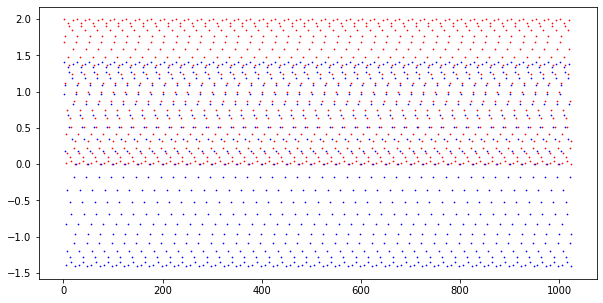

In [15]:
# Example-13: Data normalization

# Set window
win = Window.from_cosine(1024, 5.0, dtype=torch.float64, device='cpu')
print(win)

# Set TbT
tbt = Data.from_tensor(win, torch.stack([1.0 + torch.sin(2.0*numpy.pi*0.12*torch.linspace(1, 1024, 1024, dtype=win.dtype, device=win.device))]))
print(tbt)

# Normalize (change work)
# If window flag is True, window weighted mean is subtracted
tbt.normalize(window=True)
print(*torch.round(tbt.window_mean()))
print(torch.std(tbt.work))

# Plot 
time = torch.linspace(1, 1024, 1024, dtype=win.dtype)
plt.figure(figsize=(10, 5))
plt.scatter(time, tbt.data[0].detach().cpu(), c='r', s=0.5)
plt.scatter(time, tbt.work[0].detach().cpu(), c='b', s=0.5)
plt.show()

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

In [16]:
# Example-14: Convert data (return work data)

# softIoc -d virtual_tbt.db

# Set list of pv names and starting indices
bpm = ["STP2", "STP4", "STP0"]
pv_list = [pv_make(name, 'x', True) for name in bpm]
pv_rise = [0 for _ in range(len(bpm))]

# Generate test data
frequency = 0.123456
time = torch.linspace(1, 4096, 4096, dtype=torch.float64)
dat = [(10.0 + torch.randn(1))*torch.cos(2.0*numpy.pi*frequency*time) for _ in pv_list]
dat = torch.stack(dat) + 1.0

# Set window
win = Window(4096, dtype=torch.float64)
print(win)

# Set TbT
tbt = Data.from_tensor(win, dat)
tbt.pv_list = pv_list
tbt.pv_rise = pv_rise
tbt.source = 'epics'
print(tbt)

# Convert (print result)
print(tbt.to_tensor())
print(tbt.to_numpy())
print(tbt.to_dict())
print(tbt.to_data_frame())

# Clean
del win
del tbt
if device != 'cpu':
    torch.cuda.synchronize()
    torch.cuda.empty_cache()

Window(4096, None, None)
Data(3, Window(4096, None, None))
tensor([[8.456991317059e+00, 1.202645033017e+00, -6.167641278921e+00,  ...,
         -8.418882977595e+00, -8.885627248861e+00, -3.696472226966e+00],
        [7.301307438446e+00, 1.171239123075e+00, -5.056800844552e+00,  ...,
         -6.959145296683e+00, -7.353553580578e+00, -2.968613361603e+00],
        [7.099288175336e+00, 1.165749214545e+00, -4.862620437490e+00,  ...,
         -6.703975923735e+00, -7.085739518944e+00, -2.841380028725e+00]],
       dtype=torch.float64)
[[ 8.45699132  1.20264503 -6.16764128 ... -8.41888298 -8.88562725
  -3.69647223]
 [ 7.30130744  1.17123912 -5.05680084 ... -6.9591453  -7.35355358
  -2.96861336]
 [ 7.09928818  1.16574921 -4.86262044 ... -6.70397592 -7.08573952
  -2.84138003]]
{'TEST:STP2:turns_x-I': array([ 8.45699132,  1.20264503, -6.16764128, ..., -8.41888298,
       -8.88562725, -3.69647223]), 'TEST:STP4:turns_x-I': array([ 7.30130744,  1.17123912, -5.05680084, ..., -6.9591453 ,
       -7.3

## Set test data

In [1]:
# softIoc -d virtual_tbt.db

In [2]:
import epics
import numpy
import pandas
import torch

from harmonica.util import LIMIT, LENGTH, pv_make
from harmonica.window import Window
from harmonica.data import Data

torch.set_printoptions(precision=12, sci_mode=True)
torch.cuda.is_available()

True

In [3]:
win = Window(4096, dtype=torch.float64)
tbt = Data.from_file(54, win, 'virtual_tbt.npy')
tbt.data.add_(torch.rand(54).reshape(-1, 1))
tbt.reset()
std = 1.0E-4 * torch.ones(54, dtype=torch.float64)
Data.add_noise(tbt.data, std)
tbt.data[0, 128].add_(+0.025)
tbt.data[5, 256].add_(-0.025)
pv_list = ["TEST:STP2:turns_x-I", "TEST:STP4:turns_x-I", "TEST:SRP1:turns_x-I", "TEST:SRP2:turns_x-I", "TEST:SRP3:turns_x-I", "TEST:SRP4:turns_x-I", "TEST:SRP5:turns_x-I", "TEST:SRP6:turns_x-I", "TEST:SRP7:turns_x-I", "TEST:SRP8:turns_x-I", "TEST:SRP9:turns_x-I", "TEST:SIP1:turns_x-I", "TEST:SIP2:turns_x-I", "TEST:SRP10:turns_x-I", "TEST:SRP11:turns_x-I", "TEST:SRP12:turns_x-I", "TEST:SRP13:turns_x-I", "TEST:SRP14:turns_x-I", "TEST:SRP15:turns_x-I", "TEST:SRP16:turns_x-I", "TEST:SRP17:turns_x-I", "TEST:SEP5:turns_x-I", "TEST:SEP4:turns_x-I", "TEST:SEP3:turns_x-I", "TEST:SEP1:turns_x-I", "TEST:SEP0:turns_x-I", "TEST:NEP0:turns_x-I", "TEST:NEP1:turns_x-I", "TEST:NEP3:turns_x-I", "TEST:NEP4:turns_x-I", "TEST:NEP5:turns_x-I", "TEST:NRP17:turns_x-I", "TEST:NRP16:turns_x-I", "TEST:NRP15:turns_x-I", "TEST:NRP14:turns_x-I", "TEST:NRP13:turns_x-I", "TEST:NRP12:turns_x-I", "TEST:NRP11:turns_x-I", "TEST:NRP10:turns_x-I", "TEST:NIP3:turns_x-I", "TEST:NIP1:turns_x-I", "TEST:NRP9:turns_x-I", "TEST:NRP8:turns_x-I", "TEST:NRP7:turns_x-I", "TEST:NRP6:turns_x-I", "TEST:NRP5:turns_x-I", "TEST:NRP4:turns_x-I", "TEST:NRP3:turns_x-I", "TEST:NRP2:turns_x-I", "TEST:NRP1:turns_x-I", "TEST:NTP4:turns_x-I", "TEST:NTP2:turns_x-I", "TEST:NTP0:turns_x-I", "TEST:STP0:turns_x-I"]
pv_rise = [0 for _ in range(len(pv_list))]
tbt.pv_list = pv_list
tbt.pv_rise = pv_rise
tbt.save_epics()